In [1]:
import perceval as pcvl
from perceval import BS, catalog, PERM, Circuit, Processor, pdisplay, PS, BasicState, BackendFactory
from perceval.rendering.circuit import SymbSkin, DisplayConfig
from exqalibur import FockState

import numpy as np
from numpy import pi
from typing import Optional, Dict, List, Tuple

DisplayConfig.select_skin(SymbSkin)

## Avant de commencer...

In [2]:
qubits = {
    "0": BasicState([1, 0]),
    "1": BasicState([0, 1]),
    "00": BasicState([1, 0, 1, 0]),
    "01": BasicState([1, 0, 0, 1]),
    "10": BasicState([0, 1, 1, 0]),
    "11": BasicState([0, 1, 0, 1])
}
qubits_ = {qubits[k]: k for k in qubits}
sqlist = [qubits["0"], qubits["1"]]
mqlist = [qubits["00"], qubits["01"], qubits["10"], qubits["11"]]

def measure2p(processor: Processor, input_state: Optional[FockState] = None) -> Dict[FockState, float]:
    """
    Mesure le circuit directement sous forme de Processeur. Cela permet d'automatiser la gestion des "ancilla states" et
    des "heralded gates".

    :param processor:
    :param input_state:
    :return:
    """
    if input_state is None:
        input_state = qubits["00"]

    # On force la règle : la somme des photons par paire de rail doit être égale à 1.
    processor.set_postselection(pcvl.utils.PostSelect("[0,1]==1 & [2,3]==1"))
    processor.min_detected_photons_filter(0)

    # On fait finalement la mesure :
    processor.with_input(input_state)
    measure2p_s = pcvl.algorithm.Sampler(processor)

    return measure2p_s.probs()["results"]

def amplitudes(circuit):
    input_state = qubits["00"]
    output_states = mqlist
    b = BackendFactory.get_backend("Naive")
    b.set_circuit(circuit)
    b.set_input_state(input_state)
    return {qubits_[k]: roundc(b.prob_amplitude(k)) for k in output_states}

def roundc(c, decimals = 2):
    return round(c.real, decimals) + round(c.imag, decimals) * 1j

H = BS.H()
RX = BS.Rx
RY = BS.Ry
CNOT = catalog["klm cnot"].build_processor()
NOT = PERM([1, 0])
HP = Circuit(2, "HP") // H // (1, PS(-pi/2))
q = lambda x: [2*x, 2*x+1]
theta = pi/3
gamma = pi/5

# Challenge 4 : De l'inversion

Il est temps de finir cette série épouvantable de challenges. Cette fois, pas de nouvelle notion. Seulement deux circuits, et un objectif : rajouter les deux parties manquantes pour obtenir les résultats attendus. Bonne chance... que le sort vous soit favorable...

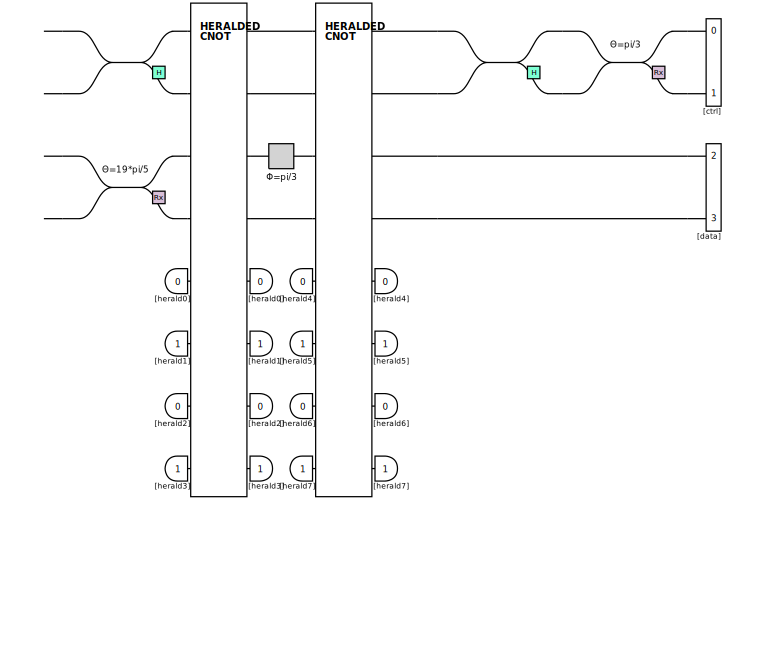

In [3]:
step_one = Circuit(2, "S1") 
p_step_one = Processor("SLOS", 4)
p_step_one.add(q(0), H)
p_step_one.add(q(1), step_one)
p_step_one.add(q(1), RX(-gamma))
p_step_one.add(q(0) + q(1), CNOT)
p_step_one.add([2], PS(theta))
p_step_one.add(q(0) + q(1), CNOT)
p_step_one.add(q(0), H)
p_step_one.add(q(0), RX(theta))
pdisplay(p_step_one)

In [4]:
print("On attend : {|1,0,0,1>: 1")
measure2p(p_step_one)[qubits["01"]]

On attend : {|1,0,0,1>: 1


0.09549150281252643

<h2 style="color:green"> Solution étape 1 : rétro-ingénierie statique </h2>

Ce petit exercice était un exemple du phénomène bien connu du retour de phase (<i>phase kickback</i>). Il pouvait néanmoins se résoudre simplement sans passer par le calcul de tout le circuit. Il suffisait par exemple de voir que le deuxième rail devait donner un $|1\rangle$ tout le temps. En remontant le circuit, on remarque qu'avant le passage des deux <i>CNOT</i>, le deuxième qubit doit forcément être à $|1\rangle$, d'où l'équation : 
$$
R_x(-\gamma) S_1 |0\rangle = |1\rangle
$$
Ou encore : 
$$
R_x(-\gamma) S_1 = X
$$
Ce qui se résout simplement avec par exemple : 
$$
R_x(-\gamma) R_x(\gamma) X = X
$$
D'où une solution possible : 
$$
S_1 = R_x(\gamma)X
$$
$$
\DeclareMathOperator{\CU}{CU}
$$
<h3 style="color:blue"> Le retour de phase</h3>
Le but du retour de phase est d'extraire de l'information sur la phase d'un qubit sans le mesurer. Pour cela, on considère le cas suivant : on possède une matrice $U$ unitaire et un circuit permettant de construire une version controllée de $U$ ($CU$). Si l'on possède aussi un vecteur propre $|\psi\rangle$ tel que : 
$$
U|\psi\rangle = e^{i\theta}|\psi\rangle
$$
alors on peut extraire $\theta$ sans avoir à mesurer directement $|\psi\rangle$. On commence par ajouter un qubit et l'on forme le circuit : 
$$
H_{\text{qubit 0}}\circ \CU \circ H_{\text{qubit 0}}
$$
Il suffit ensuite de rentrer $|0\rangle|\psi\rangle$ :
$$
|0\rangle|\psi\rangle\quad \xrightarrow{H_{\text{qubit 0}}} \quad \frac{1}{\sqrt{2}} \left(|0\rangle|\psi\rangle + |1\rangle|\psi\rangle\right)
$$
$$
\xrightarrow{\CU} \quad \frac{1}{\sqrt{2}} \left(|0\rangle|\psi\rangle + |1\rangle e^{i\theta}|\psi\rangle\right)
$$
$$
\xrightarrow{H_{\text{qubit 0}}} \quad\frac{1}{\sqrt{2}}\left(\frac{|0\rangle+|1\rangle}{\sqrt{2}}|\psi\rangle + e^{i\theta}\frac{|0\rangle -|1\rangle}{\sqrt{2}}|\psi\rangle\right) = 
\left(\frac{1+e^{i\theta}}{2}|0\rangle+ \frac{1- e^{i\theta}}{2}|1\rangle\right)|\psi\rangle = 
\left(\cos \frac{\theta}{2}~|0\rangle + \sin\frac{\theta}{2}~|1\rangle\right)|\psi\rangle
$$
En mesurant le premier qubit on obtient $|0\rangle$ avec une probabilité de :
$$
\Pr(|0\rangle)=\left|\cos\frac{\theta}{2}\right|^2
$$
Ce qui nous permet d'extraire de l'information sur $\theta$. 

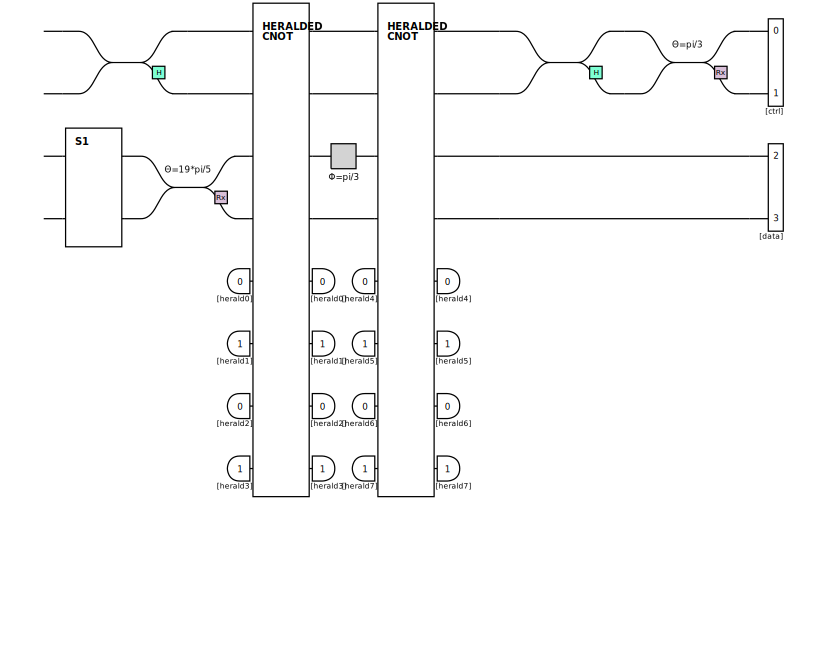

In [5]:
step_one = Circuit(2, "S1") // NOT // RX(gamma)
p_step_one = Processor("SLOS", 4)
p_step_one.add(q(0), H)
p_step_one.add(q(1), step_one)
p_step_one.add(q(1), RX(-gamma))
p_step_one.add(q(0) + q(1), CNOT)
p_step_one.add([2], PS(theta))
p_step_one.add(q(0) + q(1), CNOT)
p_step_one.add(q(0), H)
p_step_one.add(q(0), RX(theta))
pdisplay(p_step_one)

In [6]:
measure2p(p_step_one)[qubits["01"]]

1.0

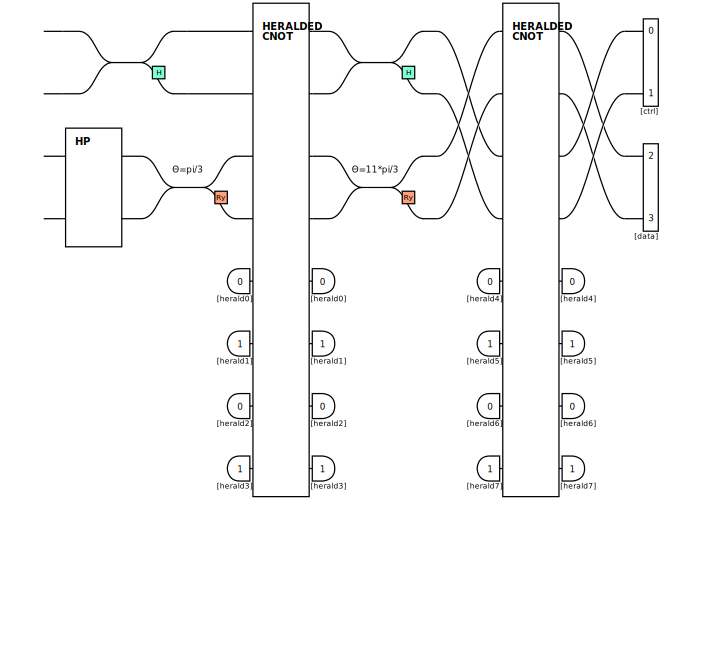

In [7]:
# step_two = Circuit(2, "S2") // RX(-pi/2)
step_two = Circuit(2, "S2") 
p_step_two = Processor("SLOS", 4)
p_step_two.add(q(0), H)
p_step_two.add(q(1), HP)
p_step_two.add(q(1), RY(theta))
p_step_two.add(q(0) + q(1), CNOT)
p_step_two.add(q(1), RY(-theta))
p_step_two.add(q(0), H)
p_step_two.add(q(1) + q(0), CNOT)
p_step_two.add(q(1), step_two)
pdisplay(p_step_two)

In [8]:
print("On attend : {|1,0,0,1>: 0.93, |0,1,0,1>: 0.07})")
measure2p(p_step_two, input_state=qubits["00"])

On attend : {|1,0,0,1>: 0.93, |0,1,0,1>: 0.07})


BSDistribution(float,
               {|1,0,1,0>: 0.4665063509461102,
                |1,0,0,1>: 0.4665063509461095,
                |0,1,1,0>: 0.03349364905389023,
                |0,1,0,1>: 0.03349364905389023})

<h2 style="color:green">Solution étape 2 : rétro-ingénierie dynamique </h2>
Une solution <i>un peu foireuse</i>, vise à ne pas regarder le circuit, mais uniquement la mesure proposée. En gardant l'identité à la place de $S_2$ on obtient la distribution suivante : 
$$
|1,0,1,0\rangle: 0.46
$$
$$
|1,0,0,1\rangle: 0.46
$$
$$
|0,1,1,0\rangle: 0.03
$$
$$
|0,1,0,1\rangle: 0.03
$$
On peut en déduire que la sortie $|\psi\rangle$ est de la forme : 
$$
|\psi\rangle = \left(\alpha |0\rangle + \beta |1\rangle \right)\otimes \left(\gamma |0\rangle + \delta |1\rangle \right)
$$
avec : 
$$
|\gamma| = |\delta|
$$
On se trouve donc à l'équateur sur la sphère de Bloch. L'objectif devient alors simple : comment passer de notre position sur l'équateur au pôle sud (deuxième qubit toujours à $|1\rangle$) ? 

Si l'on se trouve sur l'axe $X$ ou sur l'axe $Y$, il suffit de faire une rotation de $\pm \pi/2$ dans l'axe concerné. Sinon, on pourra essayer de s'y ramener avec une rotation sur $Z$. 

En essayant d'abord le cas facile, on a $4$ options : 
$$
R_x(\pi/2), \quad R_x(-\pi/2), \quad R_y(\pi/2), \quad R_y(-\pi/2)
$$
L'option $R_x(-\pi/2)$ fonctionne, c'est gagné !

<h3 style="color: blue">Notes sur la rétro-ingénierie dynamique </h3>
La rétro-ingénierie dynamique paraît intéressante d'un premier point de vue : elle permet de comprendre le fonctionnement d'un programme à n'importe quel instant, sans avoir à comprendre tout le circuit. Cependant, la physique quantique impose une grande contrainte : la mesure. Si l'on coupe le circuit en deux, on ne peut pas récupérer l'état intermédiaire $|\psi_i\rangle$, on peut seulement le mesurer. Nous n'avons pas accès à l'entièreté de l'information. Dans le cas de ce challenge, on suppose que l'état intermédiaire juste avant notre porte $S_2$ se trouve sur l'équateur, mais on a un degré de liberté inconnu : la rotation selon $Z$, et l'on est dans un cas facile ! 

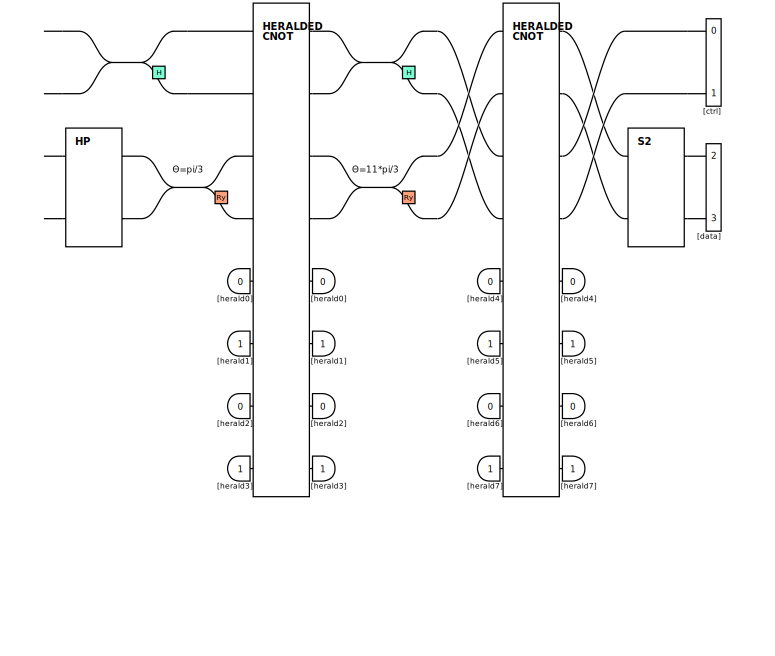

In [9]:
step_two = Circuit(2, "S2") // RX(-pi/2)
p_step_two = Processor("SLOS", 4)
p_step_two.add(q(0), H)
p_step_two.add(q(1), HP)
p_step_two.add(q(1), RY(theta))
p_step_two.add(q(0) + q(1), CNOT)
p_step_two.add(q(1), RY(-theta))
p_step_two.add(q(0), H)
p_step_two.add(q(1) + q(0), CNOT)
p_step_two.add(q(1), step_two)
pdisplay(p_step_two)

In [10]:
print("On attend : {|1,0,0,1>: 0.93, |0,1,0,1>: 0.07})")
measure2p(p_step_two, input_state=qubits["00"])

On attend : {|1,0,0,1>: 0.93, |0,1,0,1>: 0.07})


BSDistribution(float,
               {|1,0,0,1>: 0.9330127018922195, |0,1,0,1>: 0.06698729810778041})

<h2 style="color:green">Solution générale pour l'étape 1 et 2</h2>
Pour résoudre à coup sûr les deux étapes sans avoir à se poser de question, il est tout à fait possible de passer par les équations. Il <i>suffit</i> de recréer le circuit sous forme d'une matrice unitaire (pour rappel, tout circuit quantique peut s'écrire sous la forme d'une matrice unitaire qui est la multiplication des matrices des différents éléments). Puis de multiplier cette matrice par le qubit d'entré pour obtenir la sortie. On a alors plusieurs équations, qui suffisent à trouver une solution. 

Je vous propose une implémentation avec [Sage](https://www.sagemath.org/) pour la première étape : 

```python
a, b, c, d = var('a b c d')
A = matrix([[a, b], [c, d]])
H = sqrt(2) / 2 * matrix([[1, 1], [1, -1]])
Id = identity_matrix(2)
CNOT = matrix([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])
NOT = matrix([[0, 1], [1, 0]])
def PS(place, theta):
    if place == 0:
        return matrix([[e^(theta * I), 0], [0, 1]])
    else:
        return matrix([[1, 0], [0, e^(theta * I)]])
def Ry(theta):
    return matrix([[cos(theta/2), -sin(theta/2)], [sin(theta/2), cos(theta/2)]])
def Rx(theta):
    return matrix([[cos(theta/2), sin(theta/2)*I], [sin(theta/2)*I, cos(theta/2)]])
def is_unitary(matrix):
    conj_transpose = matrix.conjugate_transpose()
    return matrix * conj_transpose == identity_matrix(matrix.nrows())

gamma = pi/5
theta = pi/3

qubits = {
    "0": matrix([[1], [0]]),
    "1": matrix([[0], [1]]),
    "00": matrix([[1], [0], [0], [0]]),
    "10": matrix([[0], [1], [0], [0]]),
    "01": matrix([[0], [0], [1], [0]]),
    "11": matrix([[0], [0], [0], [1]])
}

solution_ = Rx(gamma) * NOT

C1 = H.tensor_product(Rx(-gamma) * A)
C2 = CNOT * Id.tensor_product(PS(0, theta)) * CNOT
C3 = (Rx(theta) * H).tensor_product(Id)
C = (C3 * C2 * C1 * qubits["00"]).simplify_full()
eq1 = C[0][0] == 0
eq2 = C[2][0] == 0
eq3 = C[1][0].norm() == 1
solutions = solve([eq1, eq2, eq3], [a, c])
show(solutions)
```

## Récupération du drapeau

In [ ]:
import requests as rq

def circuit_to_list(circuit: Circuit) -> List[List[Tuple[float, float]]]:
    return [[(x.real, x.imag) for x in l] for l in np.array(circuit.compute_unitary())]


d = {
    "step_one": circuit_to_list(step_one),
    "step_two": circuit_to_list(step_two),
}

# URL = "https://perceval.challenges.404ctf.fr"
URL = "http://localhost:8000"
rq.get(URL + "/healthcheck").json()

In [ ]:
rq.post(URL + "/challenges/4", json=d).json()